In this notebook, I try to classify the audio files in the famous GTZAN dataset

I have seen that many people are converting the given 30 sec audio files into 3 second files to increase the data. However, I don't agree with this approach. This is because while splitting the data into training, test and validation sets, the datapoints from the same song would be present in all these sets. This would obviously result in a high accuracy due to the skewed nature of the data.

I have therefore used the original files for classification and not split the data.

<b>Approach:</b>

I first convert the audio files into Mel Spectrograms. Then, I downloaded these Mel Spectrograms as images locally for further use.

These Mel Spectrograms can be now used as the new dataset to classify the genres. Since it is a image classification task, I use a pretrained ResNet18 model for this task.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import librosa
import librosa.display


import torch
from torch import nn
from torchvision import models, transforms, datasets

from time import time
from tqdm import tqdm

## Defining Parameters

In [2]:
seed = 12
np.random.seed(seed)

path = "../input/gtzan-dataset-music-genre-classification/"

path_audio_files = path + "Data/genres_original/"

path_imgs = "./mel_spectrogram_imgs/"

batch_size = 32

hop_length = 512

n_fft = 2048

device = 'cuda' if torch.cuda.is_available() else 'cpu'

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

## Transforming Audio Files into Mel Spectograms and Saving the Images

In [3]:
print("Transforming the Audio Files into Mel Spectrograms:")

mel_spectogram_data = {}
for genre in genre_dict.keys():
    print("\t",genre)
    
    mel_spectogram_data[genre] = []

    for name in glob.glob(path_audio_files + genre + "/*"):
        
        if(name != "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav"):
        
            data,sampling_rate = librosa.load(name)

            mel_spec = librosa.feature.melspectrogram(y = data.ravel(), sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)
            

print("Saving the Mel Spectrogram Images:")
            
os.mkdir(path_imgs)
for genre in genre_dict.keys():
    print("\t",genre)
    try:
        os.mkdir(path_imgs + genre)
    except:
        pass
    
    for i in range(len(mel_spectogram_data[genre])):

        fig, ax = plt.subplots(1, figsize=(12,8))

        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool',ax=ax)

        fig.savefig(path_imgs + genre + "/" + genre + "_" + str(i) + ".png")
        
        plt.close()

Transforming the Audio Files into Mel Spectrograms:
	 blues
	 classical
	 country
	 disco
	 hiphop
	 jazz
	 metal
	 pop
	 reggae
	 rock
Saving the Mel Spectrogram Images:
	 blues
	 classical
	 country
	 disco
	 hiphop
	 jazz
	 metal
	 pop
	 reggae
	 rock


In [4]:
import gc
gc.collect()

2037949

## Load and Transform the Data

In [5]:
%%time

# Define Tranforms
train_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

test_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

# Load the data
train_dataset = datasets.ImageFolder(path_imgs, transform = train_transforms)
val_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)
test_dataset = datasets.ImageFolder(path_imgs, transform = test_transforms)


torch.manual_seed(1)
num_train_samples = len(train_dataset)
#num_train_samples = 20000

# Permute the data
indices = torch.randperm(num_train_samples)

# Split the data into Train and Validation
train_testval_split = 0.2
train_split = int(num_train_samples * train_testval_split)
val_split = int(train_split * 0.5)

train_subset = torch.utils.data.Subset(train_dataset, indices[train_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[val_split:train_split])
test_subset = torch.utils.data.Subset(test_dataset, indices[:val_split])


print(f"Length of Train:{len(train_subset)}; Length of Val:{len(val_subset)}; Length of Test:{len(test_subset)}")



# Make DataLoaders 
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataloader.dataset.dataset.classes

Length of Train:800; Length of Val:100; Length of Test:99
CPU times: user 18.7 ms, sys: 1.37 ms, total: 20 ms
Wall time: 30.1 ms


In [6]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([-7.7954e-05, -1.2402e-04,  4.4564e-05]) tensor([0.9999, 1.0002, 1.0004])


## ResNet18 - Transfer Learning

In [7]:
# Load a Pretrained Model
resnet = models.resnet18(pretrained=True)

# Fix the trainable parameters
for parameter in resnet.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet.fc.in_features

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Training the Model

In [8]:
def train(model, criterion, optimizer, train_dataloader,test_dataloader,print_every,num_epoch):
    
    steps = 0
    train_losses, val_losses = [], []
    
    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                        
                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()
                
                
                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1]/[100]. Batch [25]/[25]. Train loss 2.191. Train acc 23.375. 

  1%|          | 1/100 [00:34<57:18, 34.73s/it]

Val loss 2.026. Val acc 38.000. Took 34.606 seconds
Epoch took 34.60697603225708
Epoch [2]/[100]. Batch [25]/[25]. Train loss 0.981. Train acc 36.500. 

  2%|▏         | 2/100 [00:59<47:02, 28.80s/it]

Val loss 1.737. Val acc 48.000. Took 24.504 seconds
Epoch took 24.504723072052002
Epoch [3]/[100]. Batch [25]/[25]. Train loss 0.600. Train acc 38.625. 

  3%|▎         | 3/100 [01:24<43:44, 27.06s/it]

Val loss 1.657. Val acc 48.000. Took 24.830 seconds
Epoch took 24.830776929855347
Epoch [4]/[100]. Batch [25]/[25]. Train loss 0.419. Train acc 48.875. 

  4%|▍         | 4/100 [01:48<41:30, 25.94s/it]

Val loss 1.575. Val acc 43.000. Took 24.117 seconds
Epoch took 24.117101907730103
Epoch [5]/[100]. Batch [25]/[25]. Train loss 0.319. Train acc 48.000. 

  5%|▌         | 5/100 [02:13<40:18, 25.46s/it]

Val loss 1.426. Val acc 60.000. Took 24.485 seconds
Epoch took 24.485589504241943
Epoch [6]/[100]. Batch [25]/[25]. Train loss 0.252. Train acc 55.250. 

  6%|▌         | 6/100 [02:37<39:20, 25.12s/it]

Val loss 1.393. Val acc 61.000. Took 24.342 seconds
Epoch took 24.34203577041626
Epoch [7]/[100]. Batch [25]/[25]. Train loss 0.205. Train acc 56.125. 

  7%|▋         | 7/100 [03:01<38:31, 24.85s/it]

Val loss 1.409. Val acc 57.000. Took 24.207 seconds
Epoch took 24.207781553268433
Epoch [8]/[100]. Batch [25]/[25]. Train loss 0.176. Train acc 56.625. 

  8%|▊         | 8/100 [03:26<37:53, 24.72s/it]

Val loss 1.312. Val acc 60.000. Took 24.297 seconds
Epoch took 24.29735827445984
Epoch [9]/[100]. Batch [25]/[25]. Train loss 0.151. Train acc 58.375. 

  9%|▉         | 9/100 [03:50<37:17, 24.59s/it]

Val loss 1.209. Val acc 65.000. Took 24.204 seconds
Epoch took 24.2045578956604
Epoch [10]/[100]. Batch [25]/[25]. Train loss 0.133. Train acc 58.125. 

 10%|█         | 10/100 [04:15<37:00, 24.67s/it]

Val loss 1.189. Val acc 62.000. Took 24.770 seconds
Epoch took 24.770497798919678
Epoch [11]/[100]. Batch [25]/[25]. Train loss 0.115. Train acc 63.375. 

 11%|█         | 11/100 [04:40<36:54, 24.88s/it]

Val loss 1.199. Val acc 60.000. Took 25.217 seconds
Epoch took 25.217743635177612
Epoch [12]/[100]. Batch [25]/[25]. Train loss 0.104. Train acc 63.875. 

 12%|█▏        | 12/100 [05:05<36:22, 24.81s/it]

Val loss 1.144. Val acc 66.000. Took 24.532 seconds
Epoch took 24.532333850860596
Epoch [13]/[100]. Batch [25]/[25]. Train loss 0.094. Train acc 63.750. 

 13%|█▎        | 13/100 [05:30<35:51, 24.73s/it]

Val loss 1.128. Val acc 62.000. Took 24.426 seconds
Epoch took 24.426452159881592
Epoch [14]/[100]. Batch [25]/[25]. Train loss 0.083. Train acc 65.750. 

 14%|█▍        | 14/100 [05:54<35:26, 24.72s/it]

Val loss 1.164. Val acc 61.000. Took 24.581 seconds
Epoch took 24.581513166427612
Epoch [15]/[100]. Batch [25]/[25]. Train loss 0.078. Train acc 66.375. 

 15%|█▌        | 15/100 [06:19<34:59, 24.70s/it]

Val loss 1.197. Val acc 62.000. Took 24.507 seconds
Epoch took 24.507153749465942
Epoch [16]/[100]. Batch [25]/[25]. Train loss 0.071. Train acc 66.875. 

 16%|█▌        | 16/100 [06:43<34:30, 24.64s/it]

Val loss 1.116. Val acc 64.000. Took 24.420 seconds
Epoch took 24.42033362388611
Epoch [17]/[100]. Batch [25]/[25]. Train loss 0.065. Train acc 65.875. 

 17%|█▋        | 17/100 [07:08<34:04, 24.63s/it]

Val loss 1.109. Val acc 62.000. Took 24.485 seconds
Epoch took 24.485793590545654
Epoch [18]/[100]. Batch [25]/[25]. Train loss 0.062. Train acc 65.250. 

 18%|█▊        | 18/100 [07:32<33:33, 24.56s/it]

Val loss 1.156. Val acc 60.000. Took 24.255 seconds
Epoch took 24.255173921585083
Epoch [19]/[100]. Batch [25]/[25]. Train loss 0.057. Train acc 67.125. 

 19%|█▉        | 19/100 [07:57<33:09, 24.56s/it]

Val loss 1.175. Val acc 60.000. Took 24.361 seconds
Epoch took 24.363568544387817
Epoch [20]/[100]. Batch [25]/[25]. Train loss 0.053. Train acc 67.000. 

 20%|██        | 20/100 [08:22<32:50, 24.63s/it]

Val loss 1.035. Val acc 66.000. Took 24.662 seconds
Epoch took 24.662566661834717
Epoch [21]/[100]. Batch [25]/[25]. Train loss 0.049. Train acc 69.625. 

 21%|██        | 21/100 [08:46<32:25, 24.62s/it]

Val loss 1.072. Val acc 65.000. Took 24.469 seconds
Epoch took 24.46972942352295
Epoch [22]/[100]. Batch [25]/[25]. Train loss 0.048. Train acc 67.375. 

 22%|██▏       | 22/100 [09:11<31:55, 24.56s/it]

Val loss 1.141. Val acc 60.000. Took 24.283 seconds
Epoch took 24.283053159713745
Epoch [23]/[100]. Batch [25]/[25]. Train loss 0.044. Train acc 68.875. 

 23%|██▎       | 23/100 [09:35<31:31, 24.56s/it]

Val loss 1.111. Val acc 61.000. Took 24.411 seconds
Epoch took 24.41175675392151
Epoch [24]/[100]. Batch [25]/[25]. Train loss 0.041. Train acc 70.000. 

 24%|██▍       | 24/100 [10:00<31:07, 24.57s/it]

Val loss 1.020. Val acc 64.000. Took 24.459 seconds
Epoch took 24.45938801765442
Epoch [25]/[100]. Batch [25]/[25]. Train loss 0.039. Train acc 71.125. 

 25%|██▌       | 25/100 [10:25<30:45, 24.61s/it]

Val loss 1.030. Val acc 64.000. Took 24.563 seconds
Epoch took 24.563442945480347
Epoch [26]/[100]. Batch [25]/[25]. Train loss 0.037. Train acc 71.875. 

 26%|██▌       | 26/100 [10:49<30:18, 24.57s/it]

Val loss 1.005. Val acc 64.000. Took 24.341 seconds
Epoch took 24.341344833374023
Epoch [27]/[100]. Batch [25]/[25]. Train loss 0.035. Train acc 72.500. 

 27%|██▋       | 27/100 [11:14<29:51, 24.54s/it]

Val loss 1.009. Val acc 66.000. Took 24.362 seconds
Epoch took 24.362175703048706
Epoch [28]/[100]. Batch [25]/[25]. Train loss 0.034. Train acc 72.750. 

 28%|██▊       | 28/100 [11:38<29:30, 24.59s/it]

Val loss 1.001. Val acc 68.000. Took 24.593 seconds
Epoch took 24.593103170394897
Epoch [29]/[100]. Batch [25]/[25]. Train loss 0.033. Train acc 71.000. 

 29%|██▉       | 29/100 [12:03<29:06, 24.60s/it]

Val loss 0.996. Val acc 63.000. Took 24.551 seconds
Epoch took 24.551299810409546
Epoch [30]/[100]. Batch [25]/[25]. Train loss 0.031. Train acc 73.250. 

 30%|███       | 30/100 [12:28<28:42, 24.61s/it]

Val loss 0.924. Val acc 67.000. Took 24.516 seconds
Epoch took 24.516374826431274
Epoch [31]/[100]. Batch [25]/[25]. Train loss 0.030. Train acc 71.125. 

 31%|███       | 31/100 [12:52<28:16, 24.58s/it]

Val loss 0.927. Val acc 70.000. Took 24.436 seconds
Epoch took 24.436882495880127
Epoch [32]/[100]. Batch [25]/[25]. Train loss 0.028. Train acc 74.875. 

 32%|███▏      | 32/100 [13:17<27:54, 24.62s/it]

Val loss 0.956. Val acc 66.000. Took 24.579 seconds
Epoch took 24.579431295394897
Epoch [33]/[100]. Batch [25]/[25]. Train loss 0.026. Train acc 75.000. 

 33%|███▎      | 33/100 [13:41<27:28, 24.60s/it]

Val loss 0.922. Val acc 68.000. Took 24.414 seconds
Epoch took 24.414700746536255
Epoch [34]/[100]. Batch [25]/[25]. Train loss 0.026. Train acc 74.500. 

 34%|███▍      | 34/100 [14:06<27:02, 24.58s/it]

Val loss 0.900. Val acc 68.000. Took 24.402 seconds
Epoch took 24.402430534362793
Epoch [35]/[100]. Batch [25]/[25]. Train loss 0.025. Train acc 73.125. 

 35%|███▌      | 35/100 [14:30<26:34, 24.53s/it]

Val loss 0.899. Val acc 67.000. Took 24.278 seconds
Epoch took 24.279221057891846
Epoch [36]/[100]. Batch [25]/[25]. Train loss 0.024. Train acc 73.250. 

 36%|███▌      | 36/100 [14:55<26:04, 24.44s/it]

Val loss 0.916. Val acc 68.000. Took 24.121 seconds
Epoch took 24.121246576309204
Epoch [37]/[100]. Batch [25]/[25]. Train loss 0.023. Train acc 74.750. 

 37%|███▋      | 37/100 [15:19<25:41, 24.47s/it]

Val loss 0.944. Val acc 66.000. Took 24.416 seconds
Epoch took 24.416956663131714
Epoch [38]/[100]. Batch [25]/[25]. Train loss 0.023. Train acc 74.500. 

 38%|███▊      | 38/100 [15:44<25:24, 24.58s/it]

Val loss 0.878. Val acc 69.000. Took 24.720 seconds
Epoch took 24.72075915336609
Epoch [39]/[100]. Batch [25]/[25]. Train loss 0.021. Train acc 75.125. 

 39%|███▉      | 39/100 [16:09<25:01, 24.62s/it]

Val loss 0.866. Val acc 70.000. Took 24.558 seconds
Epoch took 24.558101654052734
Epoch [40]/[100]. Batch [25]/[25]. Train loss 0.021. Train acc 75.625. 

 40%|████      | 40/100 [16:33<24:30, 24.51s/it]

Val loss 0.876. Val acc 70.000. Took 24.134 seconds
Epoch took 24.13498067855835
Epoch [41]/[100]. Batch [25]/[25]. Train loss 0.020. Train acc 76.750. 

 41%|████      | 41/100 [16:57<24:06, 24.52s/it]

Val loss 0.873. Val acc 69.000. Took 24.406 seconds
Epoch took 24.406288862228394
Epoch [42]/[100]. Batch [25]/[25]. Train loss 0.019. Train acc 77.750. 

 42%|████▏     | 42/100 [17:22<23:44, 24.57s/it]

Val loss 0.862. Val acc 68.000. Took 24.563 seconds
Epoch took 24.563634157180786
Epoch [43]/[100]. Batch [25]/[25]. Train loss 0.019. Train acc 77.875. 

 43%|████▎     | 43/100 [17:47<23:19, 24.56s/it]

Val loss 0.831. Val acc 72.000. Took 24.435 seconds
Epoch took 24.435914993286133
Epoch [44]/[100]. Batch [25]/[25]. Train loss 0.018. Train acc 76.375. 

 44%|████▍     | 44/100 [18:11<22:53, 24.53s/it]

Val loss 0.907. Val acc 67.000. Took 24.325 seconds
Epoch took 24.325494289398193
Epoch [45]/[100]. Batch [25]/[25]. Train loss 0.018. Train acc 77.750. 

 45%|████▌     | 45/100 [18:35<22:27, 24.49s/it]

Val loss 0.867. Val acc 69.000. Took 24.282 seconds
Epoch took 24.282716751098633
Epoch [46]/[100]. Batch [25]/[25]. Train loss 0.017. Train acc 77.000. 

 46%|████▌     | 46/100 [19:00<22:02, 24.49s/it]

Val loss 0.884. Val acc 68.000. Took 24.357 seconds
Epoch took 24.357498168945312
Epoch [47]/[100]. Batch [25]/[25]. Train loss 0.017. Train acc 76.000. 

 47%|████▋     | 47/100 [19:24<21:36, 24.46s/it]

Val loss 0.962. Val acc 66.000. Took 24.267 seconds
Epoch took 24.2672381401062
Epoch [48]/[100]. Batch [25]/[25]. Train loss 0.016. Train acc 75.500. 

 48%|████▊     | 48/100 [19:49<21:14, 24.51s/it]

Val loss 0.932. Val acc 69.000. Took 24.503 seconds
Epoch took 24.503620862960815
Epoch [49]/[100]. Batch [25]/[25]. Train loss 0.016. Train acc 78.000. 

 49%|████▉     | 49/100 [20:13<20:48, 24.48s/it]

Val loss 0.929. Val acc 67.000. Took 24.259 seconds
Epoch took 24.25918412208557
Epoch [50]/[100]. Batch [25]/[25]. Train loss 0.015. Train acc 77.750. 

 50%|█████     | 50/100 [20:38<20:23, 24.47s/it]

Val loss 0.886. Val acc 71.000. Took 24.366 seconds
Epoch took 24.366477727890015
Epoch [51]/[100]. Batch [25]/[25]. Train loss 0.014. Train acc 79.125. 

 51%|█████     | 51/100 [21:02<19:59, 24.49s/it]

Val loss 0.824. Val acc 72.000. Took 24.394 seconds
Epoch took 24.394758224487305
Epoch [52]/[100]. Batch [25]/[25]. Train loss 0.014. Train acc 78.500. 

 52%|█████▏    | 52/100 [21:27<19:38, 24.56s/it]

Val loss 0.915. Val acc 70.000. Took 24.581 seconds
Epoch took 24.581220626831055
Epoch [53]/[100]. Batch [25]/[25]. Train loss 0.014. Train acc 76.625. 

 53%|█████▎    | 53/100 [21:52<19:12, 24.53s/it]

Val loss 0.908. Val acc 69.000. Took 24.279 seconds
Epoch took 24.279198169708252
Epoch [54]/[100]. Batch [25]/[25]. Train loss 0.013. Train acc 77.875. 

 54%|█████▍    | 54/100 [22:16<18:47, 24.50s/it]

Val loss 0.943. Val acc 70.000. Took 24.314 seconds
Epoch took 24.31441879272461
Epoch [55]/[100]. Batch [25]/[25]. Train loss 0.013. Train acc 79.625. 

 55%|█████▌    | 55/100 [22:41<18:23, 24.52s/it]

Val loss 0.849. Val acc 71.000. Took 24.441 seconds
Epoch took 24.441396474838257
Epoch [56]/[100]. Batch [25]/[25]. Train loss 0.013. Train acc 79.500. 

 56%|█████▌    | 56/100 [23:05<18:02, 24.60s/it]

Val loss 0.893. Val acc 72.000. Took 24.637 seconds
Epoch took 24.637142419815063
Epoch [57]/[100]. Batch [25]/[25]. Train loss 0.012. Train acc 78.750. 

 57%|█████▋    | 57/100 [23:30<17:37, 24.60s/it]

Val loss 0.852. Val acc 69.000. Took 24.466 seconds
Epoch took 24.46656847000122
Epoch [58]/[100]. Batch [25]/[25]. Train loss 0.012. Train acc 81.000. 

 58%|█████▊    | 58/100 [23:54<17:12, 24.58s/it]

Val loss 0.843. Val acc 71.000. Took 24.429 seconds
Epoch took 24.429584980010986
Epoch [59]/[100]. Batch [25]/[25]. Train loss 0.012. Train acc 80.625. 

 59%|█████▉    | 59/100 [24:19<16:48, 24.59s/it]

Val loss 0.892. Val acc 72.000. Took 24.487 seconds
Epoch took 24.487506866455078
Epoch [60]/[100]. Batch [25]/[25]. Train loss 0.012. Train acc 79.625. 

 60%|██████    | 60/100 [24:44<16:23, 24.59s/it]

Val loss 0.873. Val acc 68.000. Took 24.471 seconds
Epoch took 24.471306324005127
Epoch [61]/[100]. Batch [25]/[25]. Train loss 0.011. Train acc 80.375. 

 61%|██████    | 61/100 [25:08<15:59, 24.59s/it]

Val loss 0.799. Val acc 72.000. Took 24.468 seconds
Epoch took 24.468767642974854
Epoch [62]/[100]. Batch [25]/[25]. Train loss 0.011. Train acc 79.500. 

 62%|██████▏   | 62/100 [25:33<15:34, 24.59s/it]

Val loss 0.879. Val acc 71.000. Took 24.396 seconds
Epoch took 24.39603590965271
Epoch [63]/[100]. Batch [25]/[25]. Train loss 0.011. Train acc 79.125. 

 63%|██████▎   | 63/100 [25:57<15:09, 24.59s/it]

Val loss 0.809. Val acc 72.000. Took 24.462 seconds
Epoch took 24.46205234527588
Epoch [64]/[100]. Batch [25]/[25]. Train loss 0.011. Train acc 81.375. 

 64%|██████▍   | 64/100 [26:22<14:46, 24.62s/it]

Val loss 0.812. Val acc 72.000. Took 24.569 seconds
Epoch took 24.56944489479065
Epoch [65]/[100]. Batch [25]/[25]. Train loss 0.010. Train acc 80.000. 

 65%|██████▌   | 65/100 [26:47<14:21, 24.60s/it]

Val loss 0.969. Val acc 68.000. Took 24.451 seconds
Epoch took 24.451116800308228
Epoch [66]/[100]. Batch [25]/[25]. Train loss 0.010. Train acc 80.875. 

 66%|██████▌   | 66/100 [27:11<13:55, 24.58s/it]

Val loss 0.917. Val acc 70.000. Took 24.389 seconds
Epoch took 24.389423847198486
Epoch [67]/[100]. Batch [25]/[25]. Train loss 0.010. Train acc 80.000. 

 67%|██████▋   | 67/100 [27:36<13:28, 24.51s/it]

Val loss 0.920. Val acc 70.000. Took 24.237 seconds
Epoch took 24.237288236618042
Epoch [68]/[100]. Batch [25]/[25]. Train loss 0.010. Train acc 80.625. 

 68%|██████▊   | 68/100 [28:00<13:05, 24.56s/it]

Val loss 0.886. Val acc 72.000. Took 24.533 seconds
Epoch took 24.533541202545166
Epoch [69]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 81.000. 

 69%|██████▉   | 69/100 [28:25<12:41, 24.56s/it]

Val loss 0.919. Val acc 69.000. Took 24.436 seconds
Epoch took 24.43626117706299
Epoch [70]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 80.500. 

 70%|███████   | 70/100 [28:49<12:16, 24.55s/it]

Val loss 0.882. Val acc 68.000. Took 24.399 seconds
Epoch took 24.399598360061646
Epoch [71]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 82.000. 

 71%|███████   | 71/100 [29:14<11:50, 24.52s/it]

Val loss 0.912. Val acc 68.000. Took 24.267 seconds
Epoch took 24.26738715171814
Epoch [72]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 82.000. 

 72%|███████▏  | 72/100 [29:38<11:26, 24.53s/it]

Val loss 0.834. Val acc 71.000. Took 24.435 seconds
Epoch took 24.435988187789917
Epoch [73]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 81.625. 

 73%|███████▎  | 73/100 [30:03<11:02, 24.55s/it]

Val loss 0.815. Val acc 73.000. Took 24.506 seconds
Epoch took 24.506253957748413
Epoch [74]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 82.250. 

 74%|███████▍  | 74/100 [30:28<10:39, 24.58s/it]

Val loss 0.918. Val acc 70.000. Took 24.528 seconds
Epoch took 24.528371334075928
Epoch [75]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 80.750. 

 75%|███████▌  | 75/100 [30:52<10:14, 24.58s/it]

Val loss 0.849. Val acc 68.000. Took 24.430 seconds
Epoch took 24.430505752563477
Epoch [76]/[100]. Batch [25]/[25]. Train loss 0.009. Train acc 80.625. 

 76%|███████▌  | 76/100 [31:17<09:48, 24.52s/it]

Val loss 0.848. Val acc 71.000. Took 24.253 seconds
Epoch took 24.253784656524658
Epoch [77]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 83.000. 

 77%|███████▋  | 77/100 [31:41<09:25, 24.59s/it]

Val loss 0.848. Val acc 74.000. Took 24.646 seconds
Epoch took 24.646897554397583
Epoch [78]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 82.375. 

 78%|███████▊  | 78/100 [32:06<09:00, 24.58s/it]

Val loss 0.930. Val acc 71.000. Took 24.439 seconds
Epoch took 24.439231872558594
Epoch [79]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 83.750. 

 79%|███████▉  | 79/100 [32:31<08:40, 24.81s/it]

Val loss 0.847. Val acc 70.000. Took 25.204 seconds
Epoch took 25.204814672470093
Epoch [80]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 82.250. 

 80%|████████  | 80/100 [32:56<08:15, 24.76s/it]

Val loss 0.848. Val acc 70.000. Took 24.469 seconds
Epoch took 24.474949836730957
Epoch [81]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 82.250. 

 81%|████████  | 81/100 [33:20<07:48, 24.67s/it]

Val loss 0.863. Val acc 71.000. Took 24.336 seconds
Epoch took 24.33615231513977
Epoch [82]/[100]. Batch [25]/[25]. Train loss 0.008. Train acc 82.375. 

 82%|████████▏ | 82/100 [33:45<07:23, 24.63s/it]

Val loss 0.876. Val acc 67.000. Took 24.397 seconds
Epoch took 24.397384881973267
Epoch [83]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 82.250. 

 83%|████████▎ | 83/100 [34:10<06:59, 24.65s/it]

Val loss 0.917. Val acc 67.000. Took 24.556 seconds
Epoch took 24.556607007980347
Epoch [84]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 81.375. 

 84%|████████▍ | 84/100 [34:34<06:34, 24.68s/it]

Val loss 0.850. Val acc 71.000. Took 24.636 seconds
Epoch took 24.63609504699707
Epoch [85]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 82.500. 

 85%|████████▌ | 85/100 [34:59<06:09, 24.63s/it]

Val loss 0.841. Val acc 73.000. Took 24.349 seconds
Epoch took 24.349689483642578
Epoch [86]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 81.500. 

 86%|████████▌ | 86/100 [35:24<05:45, 24.65s/it]

Val loss 0.832. Val acc 71.000. Took 24.577 seconds
Epoch took 24.577243089675903
Epoch [87]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 83.250. 

 87%|████████▋ | 87/100 [35:48<05:20, 24.65s/it]

Val loss 0.863. Val acc 72.000. Took 24.501 seconds
Epoch took 24.501154899597168
Epoch [88]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 82.625. 

 88%|████████▊ | 88/100 [36:13<04:56, 24.67s/it]

Val loss 0.886. Val acc 72.000. Took 24.593 seconds
Epoch took 24.593409776687622
Epoch [89]/[100]. Batch [25]/[25]. Train loss 0.007. Train acc 81.875. Val loss 0.830. Val acc 73.000. Took 24.430 seconds
Epoch took 24.43126893043518


 89%|████████▉ | 89/100 [36:38<04:31, 24.66s/it]

Epoch [90]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 82.375. 

 90%|█████████ | 90/100 [37:02<04:06, 24.68s/it]

Val loss 0.832. Val acc 70.000. Took 24.568 seconds
Epoch took 24.568625926971436
Epoch [91]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 84.625. 

 91%|█████████ | 91/100 [37:27<03:41, 24.63s/it]

Val loss 0.795. Val acc 71.000. Took 24.370 seconds
Epoch took 24.37035298347473
Epoch [92]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 82.875. 

 92%|█████████▏| 92/100 [37:51<03:16, 24.61s/it]

Val loss 0.798. Val acc 72.000. Took 24.423 seconds
Epoch took 24.42356824874878
Epoch [93]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 82.750. 

 93%|█████████▎| 93/100 [38:16<02:52, 24.60s/it]

Val loss 0.843. Val acc 71.000. Took 24.449 seconds
Epoch took 24.44944405555725
Epoch [94]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 84.000. 

 94%|█████████▍| 94/100 [38:40<02:27, 24.53s/it]

Val loss 0.869. Val acc 70.000. Took 24.222 seconds
Epoch took 24.22260093688965
Epoch [95]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 85.250. 

 95%|█████████▌| 95/100 [39:05<02:02, 24.54s/it]

Val loss 0.807. Val acc 74.000. Took 24.441 seconds
Epoch took 24.44195246696472
Epoch [96]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 85.000. 

 96%|█████████▌| 96/100 [39:29<01:38, 24.57s/it]

Val loss 0.810. Val acc 73.000. Took 24.506 seconds
Epoch took 24.506998777389526
Epoch [97]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 85.000. 

 97%|█████████▋| 97/100 [39:54<01:13, 24.51s/it]

Val loss 0.863. Val acc 71.000. Took 24.228 seconds
Epoch took 24.228190422058105
Epoch [98]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 85.125. 

 98%|█████████▊| 98/100 [40:18<00:48, 24.46s/it]

Val loss 0.805. Val acc 75.000. Took 24.260 seconds
Epoch took 24.260347843170166
Epoch [99]/[100]. Batch [25]/[25]. Train loss 0.006. Train acc 84.000. 

 99%|█████████▉| 99/100 [40:43<00:24, 24.52s/it]

Val loss 0.816. Val acc 70.000. Took 24.515 seconds
Epoch took 24.515900373458862
Epoch [100]/[100]. Batch [25]/[25]. Train loss 0.005. Train acc 86.000. 

100%|██████████| 100/100 [41:07<00:00, 24.68s/it]

Val loss 0.856. Val acc 70.000. Took 24.448 seconds
Epoch took 24.448478937149048


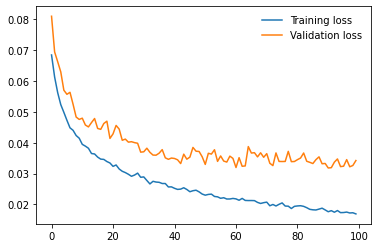

In [9]:
print_every = 25
num_epoch = 100

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Testing

In [10]:
y_test = []
y_pred = []
for img, label in test_subset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])
    
    final_pred = classes[torch.max(prediction, dim=1)[1]]
    
    #print(label, genre_dict[final_pred])
    
    y_test.append(label)
    y_pred.append(genre_dict[final_pred])


In [11]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 69.6969696969697


This seems to be a good baseline model for this task.

I'll be trying to improve the performance by including more preprocessed features which I have detailed in [this notebook](https://www.kaggle.com/code/nippani/preprocessing-audio-data-gtzan).

If you liked this notebook, please upvote.

Also, do let me know if there are any corrections/additions needed.